In [2]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

#from pydub import AudioSegment
from td_utils import *

In [142]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling2D, AveragePooling3D
from keras.layers import Conv2D,Conv3D
from keras.backend import transpose
from keras.optimizers import Adam
from keras.regularizers import L1L2

(10, 10, 4000)


<Figure size 432x288 with 0 Axes>

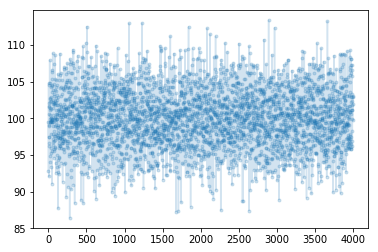

<Figure size 432x288 with 0 Axes>

In [18]:
i = randint(0,900)
home = "/export/home1/users/bssn/serna"
datadir = home+"/SyntheticData/syndat/"
Ft = load(datadir+"d"+str(i).zfill(4)+".npy")

Ftsh = Ft.shape
width,height,T = Ftsh  
print(Ftsh)
t = arange(Ftsh[-1])
figure()
plot(t,sum(sum(Ft,axis=0),axis=0),'.-',alpha=0.2)
figure()

In [13]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

In [14]:
def is_overlapping(segment_time, previous_segments):
    '''
    This function checks if the time of a segment overlaps with the
    existing segments.
    '''
    s_start, s_end = segment_time
    
    overlap = False
    
    for prev_start, prev_end in previous_segments:
        if s_start <= prev_end and s_end >= prev_start:
            overlap = True
    
    return overlap

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [22]:
param = load(datadir+"p"+str(i).zfill(4)+".npy")
imo2 = load(datadir+"o2_"+str(i).zfill(4)+".npy")
imo4 = load(datadir+"o4_"+str(i).zfill(4)+".npy")
imo8 = load(datadir+"o8_"+str(i).zfill(4)+".npy")

print(param.shape)
print(imo2.shape,imo4.shape,imo8.shape)

(5, 3)
(20, 20) (40, 40) (80, 80)


In [234]:
# 1 segundo. This will be used as another (meta)parameter, 
# which we want to decrease
nframes = 1000


X = []
Y = []
for i in range(800):
    xt = load(datadir+"d"+str(i).zfill(4)+".npy")
    yt = load(datadir+"o4_"+str(i).zfill(4)+".npy")
    #par = pars[i]
    #xt = reshape(xt,(width*height,T))
    #yt = reshape(yt,(4*width*height))
    for j in range(5):
        start,end = get_random_time_segment(nframes,T)
        X.append(xt[:,:,start:end])
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(yt)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
for i in range(800,900):
    xt = load(datadir+"d"+str(i).zfill(4)+".npy")
    yt = load(datadir+"o4_"+str(i).zfill(4)+".npy")
    #par = pars[i]
    #xt = reshape(xt,(width*height,T))
    #yt = reshape(yt,(4*width*height))
    for j in range(5):
        start,end = get_random_time_segment(nframes,T)
        Xdev.append(xt[:,:,start:end])
        #Ydev.append(concatenate((yt[start:end],par[-1:])))
        Ydev.append(yt)
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)


'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

(4000, 10, 10, 1000) (4000, 40, 40)
(500, 10, 10, 1000) (500, 40, 40)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

In [ ]:
end

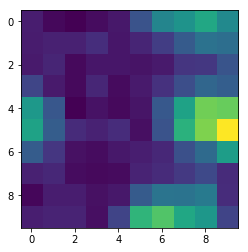

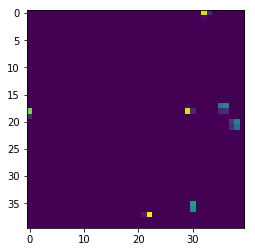

In [235]:
colors = array(['C0','C1'])
t = arange(1000)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[1])
imshow(sum(X[i,:,:],axis=-1))
figure()
imshow(Y[i,:])

In [240]:
print(X.shape)
print(Y.shape)
print(Xdev.shape)
print(Ydev.shape)
width

(4000, 10, 10, 1000, 1)
(4000, 40, 40, 1, 1)
(500, 10, 10, 1000, 1)
(500, 40, 40, 1, 1)


10

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [237]:
X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],Xdev.shape[2],Xdev.shape[3],1))
Ydev = reshape(Ydev,(Ydev.shape[0],Ydev.shape[1],Ydev.shape[2],1,1))

In [257]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    
    magn = 4
    X_input = Input(shape = input_shape)
    
    w,h,T,_ = input_shape
    # Layers

    X = X_input

    X = Conv3D(20,(2,2,50),strides=(1,1,20),padding="same")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    X = Dropout(0.1)(X)
    X = Dense(10,activation="relu")(X)

    
    Xa = MaxPooling3D((4,4,100),strides=(1,1,10),padding="same")(X)
    Xb = AveragePooling3D((4,4,100),strides=(1,1,10),padding="same")(X)
    Xc = Conv3D(10,(4,4,50),strides=(1,1,5),padding="same")(X)
    
    X = Concatenate(axis=3)([Xa,Xb,Xc])

    X = Dropout(0.1)(X)
    X = Dense(40,activation="relu")(X)

    X = Conv3D(magn*magn*10,(1,1,20),strides=(1,1,1),padding="valid")(X)
    
    X = Reshape((10*magn,10*magn,1,10))(X)
    #Xa = Conv1D(20,10,strides = 4,padding="same")(Xa)
    #Xa = BatchNormalization()(Xa)
    #Xa = Activation("relu")(Xa)

    #Xa = Conv1D(40,5,strides = 2,padding="same")(Xa)
    #Xa = BatchNormalization()(Xa)
    #Xa = Activation("relu")(Xa)

    #X = Dense(10,activation="relu")(Xa)
    #X = Dense(16,activation="relu")(X)
    #Xb = Dense(10,activation="softmax")(X)
    #X = Concatenate()([Xa,Xb])
    #X = Reshape((2000,2))(X)

    X = Dense(1,activation="sigmoid")(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [258]:
model = model(input_shape = (width,height,nframes,1))

In [259]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 10, 10, 1000, 0                                            
__________________________________________________________________________________________________
conv3d_71 (Conv3D)              (None, 10, 10, 50, 2 4020        input_61[0][0]                   
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 10, 10, 50, 2 80          conv3d_71[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 10, 10, 50, 2 0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
dropout_45

### Fit the model!

In [260]:
from keras.optimizers import SGD

In [262]:
opt = Adam(lr=0.0005, beta_1=0.90, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])


In [263]:
Wsave = model.get_weights()
#model.set_weights(Wsave)

In [ ]:
history3 = model.fit(X, Y, batch_size = 500, epochs = 40)

Epoch 1/40
4000/4000 [==============================] - 10s 3ms/step - loss: 0.2093 - acc: 0.8884
Epoch 2/40
4000/4000 [==============================] - 9s 2ms/step - loss: 0.0292 - acc: 0.9635
Epoch 3/40
4000/4000 [==============================] - 8s 2ms/step - loss: 0.0317 - acc: 0.9635
Epoch 4/40
4000/4000 [==============================] - 8s 2ms/step - loss: 0.0316 - acc: 0.9635
Epoch 5/40
4000/4000 [==============================] - 8s 2ms/step - loss: 0.0315 - acc: 0.9635
Epoch 6/40
4000/4000 [==============================] - 9s 2ms/step - loss: 0.0312 - acc: 0.9635
Epoch 7/40
4000/4000 [==============================] - 8s 2ms/step - loss: 0.0307 - acc: 0.9635
Epoch 8/40
4000/4000 [==============================] - 9s 2ms/step - loss: 0.0300 - acc: 0.9635
Epoch 9/40
4000/4000 [==============================] - 8s 2ms/step - loss: 0.0295 - acc: 0.9635
Epoch 10/40
4000/4000 [==============================] - 8s 2ms/step - loss: 0.0292 - acc: 0.9635
Epoch 11/40
4000/4000 [=====

In [ ]:
#Wsave_trained1 = model.get_weights()
Wsave_trained4 = model.get_weights()
#Wsave_trained3 = model.get_weights()

In [215]:
figure()
print(history2.history.keys())
#plot(history.history['acc'])
plot(history2.history['acc'])
title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
plot(history2.history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')


NameError: name 'history2' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

In [164]:
%matplotlib notebook

<IPython.core.display.Javascript object>


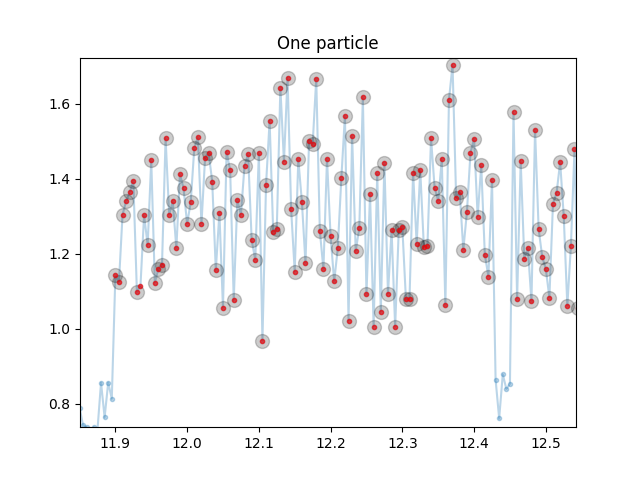

8.14 8.025 0.115 0.02


In [165]:
figure()
i = 4031
a = load("syndat/d"+str(i).zfill(4)+".npy");
b = load("syndat/r"+str(i).zfill(4)+".npy");
n0 = randint(0,12000-nframes)
#n0 = 5000
t = arange(12000)*5e-3
start, end = (n0,n0+nframes)
b = b[start:end]

if pars[i][-1]>1:
    title("Cluster with "+str(int(pars[i][-1]))+" particles")
else:
    title("One particle")
plot(t[start:end],a[start:end],'.-',alpha=0.3)
xt = reshape(a[start:end],(1,nframes,1))
y = model.predict(xt)[0,:,0]
plot(t[start:end][y<=0.5],a[start:end][y<=0.5],'ko',alpha=0.2,ms=10)
plot(t[start:end][b==0],a[start:end][b==0],'r.',alpha=0.6)

total0 = sum(b==0)/200
totalac = sum((b==0)*(y<=0.5))/200
totalfn =sum((b==0)*(y>=0.5))/200
totalfp =sum((b==1)*(y<=0.5))/200
print(total0,totalac,totalfn,totalfp)

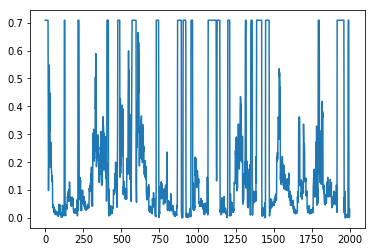

In [166]:
%matplotlib inline
xt = reshape(a[start:end],(1,2000,1))
plot(model.predict(xt)[0,:,0])

In [104]:
historybkp = history2

In [302]:
model.save("network20180417c.h5")

In [21]:
h5py

<module 'h5py' from '/home/pablo/environments/deeplearning/lib/python3.6/site-packages/h5py/__init__.py'>

## Real Data
### Control first

What is it going to happeeeennn!!!!!!!?!?!??!?!?!?!?!?!?



In [168]:
basedir = "realcontrol/"
filesA = os.listdir(basedir)
files = []
for file in filesA:
    if file[-4:]==".npy":
        files.append(basedir+file)
print(len(files))


33


In [169]:
files

['realcontrol/_control_no voltage_2__13.npy',
 'realcontrol/_control_no voltage__10.npy',
 'realcontrol/_control_no voltage_2__09.npy',
 'realcontrol/_control_no voltage_2__12.npy',
 'realcontrol/_control_no voltage_2__18.npy',
 'realcontrol/_control_no voltage_2__07.npy',
 'realcontrol/_control_no voltage_2__06.npy',
 'realcontrol/_control_no voltage__09.npy',
 'realcontrol/_control_no voltage__03.npy',
 'realcontrol/_control_no voltage_2__15.npy',
 'realcontrol/_control_no voltage_2__04.npy',
 'realcontrol/_control_no voltage__05.npy',
 'realcontrol/_control_no voltage_2__19.npy',
 'realcontrol/_control_no voltage__11.npy',
 'realcontrol/_control_no voltage_2__11.npy',
 'realcontrol/_control_no voltage_2__05.npy',
 'realcontrol/_control_no voltage__04.npy',
 'realcontrol/_control_no voltage__06.npy',
 'realcontrol/_control_no voltage__13.npy',
 'realcontrol/_control_no voltage_2__17.npy',
 'realcontrol/_control_no voltage_2__03.npy',
 'realcontrol/_control_no voltage__02.npy',
 'real

In [219]:
n0 = randint(len(files))
#n0 = -5
a = load(files[n0]);
print(n0+1)

15


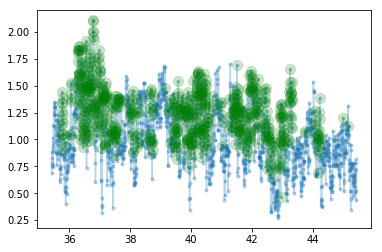

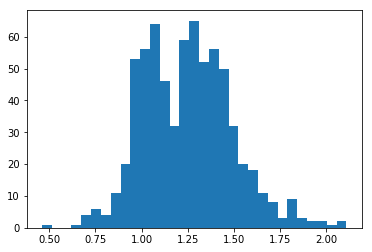

In [225]:
figure("Control")

n0 = randint(0,12000-nframes)
#n0 = 12*200
t = arange(12000)*5e-3
start, end = (n0,n0+nframes)

plot(t[start:end],a[start:end],'.-',alpha=0.3)
xt = reshape(a[start:end],(1,nframes,1))
y = model.predict(xt)[0,:,0]
plot(t[start:end][y<=0.5],a[start:end][y<=0.5],'go',alpha=0.2,ms=10)
figure()
hist(a[start:end][y<=0.5],bins=31);